In [ ]:
"""
!mkdir pretrained_checkpoint
!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_h.pth
!mv sam_hq_vit_h.pth pretrained_checkpoint
"""

'\n!mkdir pretrained_checkpoint\n!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth\n!mv sam_hq_vit_l.pth pretrained_checkpoint\n'

#### 0.라이브러리 import

In [ ]:
import numpy as np
from PIL import Image
from BLDSAG1024 import *

 

# - device는 SAM과 BLDCSAG768의 device를 다르게 설정해주세요.
SAM_device = 'cuda:7'
BLDCSAG_device = 'cuda:3'

/intern1/mmai06/[mmai06]/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/intern1/mmai06/[mmai06]/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/intern1/mmai06/[mmai06]/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/intern1/mmai06/[mmai06]/lib/python3.10/site-packages/segment_anything_hq/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment

#### 1. Mask generation을 위한 input_box 생성 과정

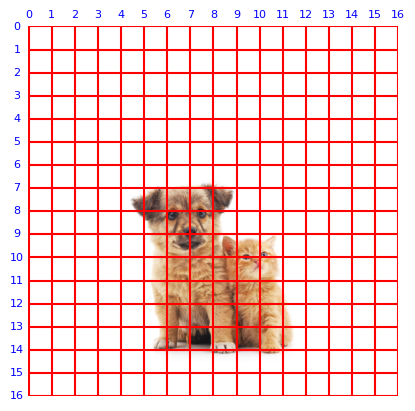

In [3]:
## 1 ## Mask generation을 위한 coord 확인
image_path = "/intern1/mmai06/Image_source/img.png"
image_grid = ImageGrid(image_path)
image_grid.draw_grid()

#### 1.2 SAM-HQ로 object mask 생성

In [4]:
# - coord는 (x1, y1, x2, y2)로 값 순서를 반드시 지켜주세요. (Default: (2,2,14,14))
img_processor = SamHQImageProcessor(img_path=image_path, device = SAM_device, coord=(4,6,12,15))
img_processor.run()

/intern1/mmai06/[mmai06]/lib/python3.10/site-packages/segment_anything_hq/build_sam.py:160: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


<All keys matched successfully>


### 2.pipeline 불러오기

In [5]:
controlnet = controlnet=ControlNetModel.from_pretrained('thibaud/controlnet-sd21-canny-diffusers', torch_dtype=torch.float16, cross_attention_dim=1024)

An error occurred while trying to fetch thibaud/controlnet-sd21-canny-diffusers: thibaud/controlnet-sd21-canny-diffusers does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [6]:
prompt='They are sitting on the Central park in the New York city'
negative_prompt = "low quality, blurry, distorted, out of focus, low resolution, bad anatomy, bad proportions, extra limbs, missing limbs"

pipe = BLDCSAG1024('stabilityai/stable-diffusion-2-1', controlnet = controlnet,
    prompt=prompt,
    negative_prompt=negative_prompt,
    # init_image='image.png',
    # mask='mask.png',
    # model_path='stabilityai/stable-diffusion-2-1',
    # controlnet_model_path='thibaud/controlnet-sd21-canny-diffusers',  # ControlNet SD 2.1 Canny model path
    blending_start_percentage = 0.1,
    device = BLDCSAG_device,
    # output_path='output.png'
)


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


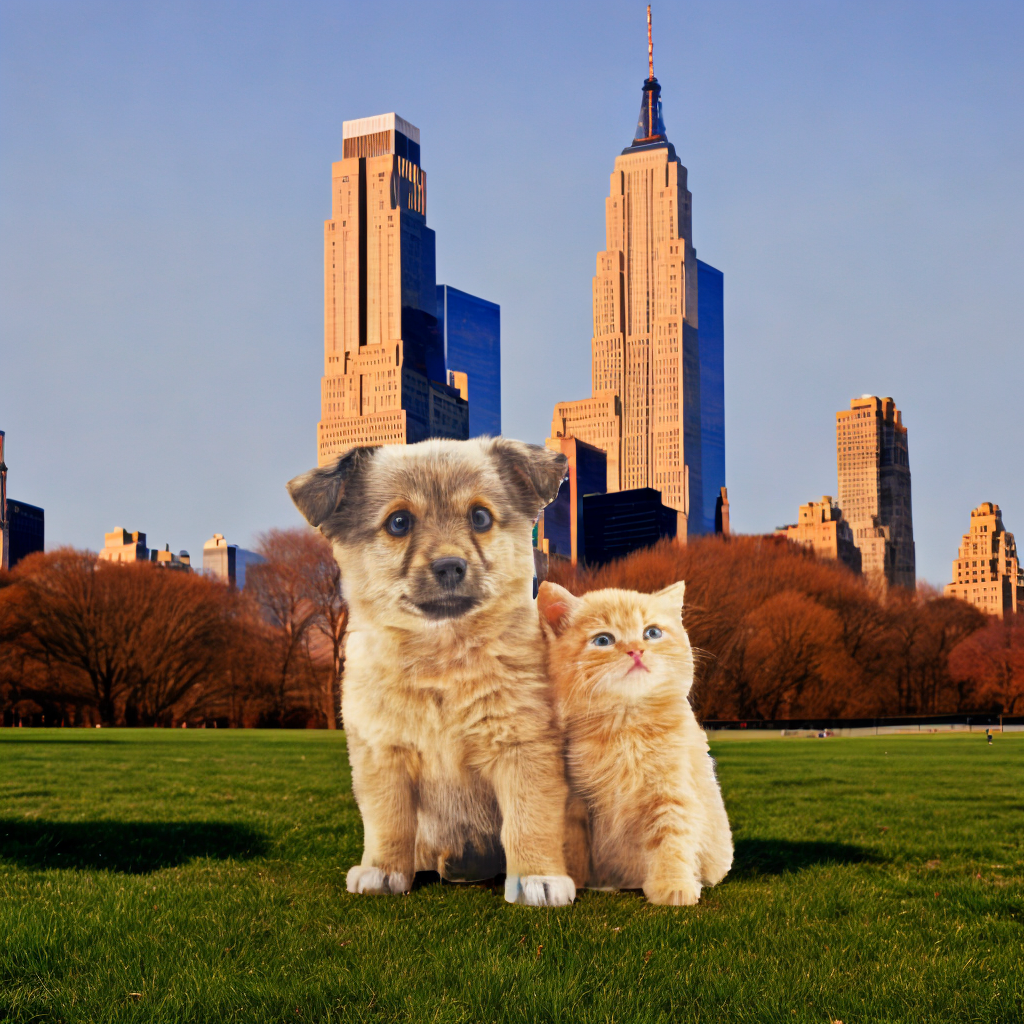

In [7]:
results = pipe.generate_image(
    kernel_size = 2,            # Default : 1
    num_inference_steps=50,     # Default : 100
    guidance_scale=7.0,         # Default : 7.0
    sag_scale = 0.7,            # Default : 0.8 
    seed = 1998,             # Default : None(random)    
)


results_flat = np.concatenate(results, axis=1)
output = Image.fromarray(results_flat)
output.save('output.png')
output


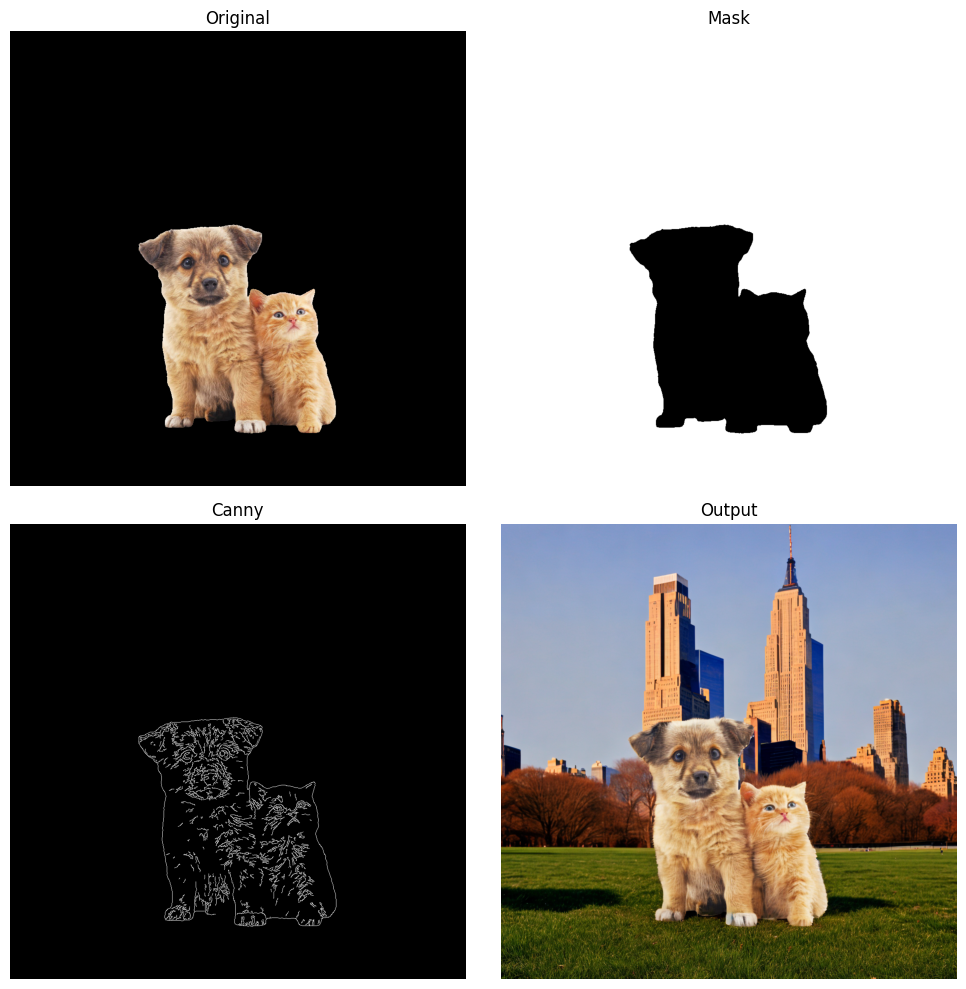

In [8]:
img_display = ImageGridDisplay('image.png', 'mask.png', 'canny.png', 'output.png')
img_display.display()